In [6]:
import pandas as pd
import geopandas as gpd
#import geoplot
from shapely.geometry import Point
from shapely.ops import nearest_points
from math import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
arrests  = pd.read_csv('../data/Fare Evasion Arrests.csv')


In [3]:
gp_arrests = gpd.GeoDataFrame(arrests[['ARREST_KEY', 'Latitude', 'Longitude', 'JURISDICTION_CODE']], geometry= [Point(x, y) for x, y in zip(arrests.Longitude, arrests.Latitude)])

In [7]:
stations = gpd.read_file('../data/Subway Stations/geo_export_d1cef8bd-bb80-491b-983e-fc4b3e3aab4f.shp')

In [8]:
unary = stations.geometry.unary_union

In [9]:
#https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
def dist_nearest_station(point, pts=unary):
     # find the nearest station and return the corresponding distance to that station
    nearest = stations.geometry == nearest_points(point, pts)[1]
    
    
    longs = stations[nearest].iloc[0].geometry.x
    lats = stations[nearest].iloc[0].geometry.y
    longp = point.x
    latp = point.y
    
    return haversine(longs, lats, longp, latp)

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in km. Use 3956 for miles
    
    return c * r *1000 #conver to m

In [10]:
sample = gp_arrests.sample(10)

In [11]:
#this can take a while
gp_arrests['DistToStation'] = gp_arrests.apply(lambda row: dist_nearest_station(row.geometry), axis=1)

In [5]:
gp_arrests.head()

,ARREST_KEY,Latitude,Longitude,JURISDICTION_CODE,geometry
0,173114463,40.769437,-73.910241,0.0,POINT (-73.91024 40.76944)
1,173113521,40.773650,-73.959857,1.0,POINT (-73.95986 40.77365)
2,173114460,40.792167,-73.969896,0.0,POINT (-73.96990 40.79217)
3,173114446,40.819702,-73.901603,1.0,POINT (-73.90160 40.81970)
4,173093896,40.866076,-73.894376,1.0,POINT (-73.89438 40.86608)


In [12]:
#some very large distances here, thousands of km, lets get rid of some outliers
gp_arrests.DistToStation.describe()

count    2.922670e+05
mean     2.533520e+03
std      4.634656e+04
min      1.753994e-01
25%      2.049044e+01
50%      5.074656e+01
75%      1.091894e+02
max      2.355108e+06
Name: DistToStation, dtype: float64

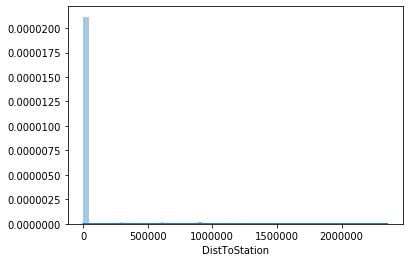

In [146]:
sns.distplot(gp_arrests.DistToStation)

In [147]:
def find_outliers(df_series, multiple_IQR):
    """
    For a series of numerical values, remove the zeros and identify the upper outliers 
    to return a mask for all outliers in series
    """
    non_zeros = df_series.replace(0, None)
    
    adjusted_IQR = (non_zeros.quantile(.75) - non_zeros.quantile(.25)) * multiple_IQR
    outlier_lim = non_zeros.quantile(.75) + adjusted_IQR
    print(outlier_lim)
    
    outliers = [True if x > outlier_lim else False for x in df_series]
    
    outlier_count = sum(outliers)
    all_data_count = len(df_series)
    print('{} outliers identified: {} of all data'.format(outlier_count, round(outlier_count/all_data_count,6)))
    
    return outliers

In [149]:
print('All Data Len:', len(gp_arrests))
print('Outliers greater than')
gp_arrests['outliers'] = find_outliers(gp_arrests['DistToStation'], 20)

#delete these outliers detected here
clean_df = gp_arrests.loc[(~gp_arrests['outliers'])].copy()
print('Excluding Outliers Len:', len(clean_df))

print('Keeping', round(len(clean_df)/len(gp_arrests), 6))

All Data Len: 292267
Outliers greater than
1883.168983574281
2399 outliers identified: 0.008208 of all data
Excluding Outliers Len: 289868
Keeping 0.991792


In [151]:
clean_df.DistToStation.describe()

count    289868.000000
mean         98.507037
std         173.509672
min           0.175399
25%          20.490441
50%          50.480662
75%         107.826143
max        1865.959429
Name: DistToStation, dtype: float64

Text(0.5, 1.0, 'Distribution of Arrest Distances from Nearest Subway Stop')

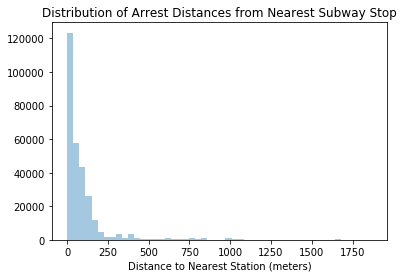

In [156]:
ax = sns.distplot(clean_df.DistToStation, kde=False)
ax.set_xlabel('Distance to Nearest Station (meters)')
ax.set_title('Distribution of Arrest Distances from Nearest Subway Stop')

In [160]:
clean_df.groupby(['JURISDICTION_CODE']).DistToStation.describe()

,count,mean,std,min,25%,50%,75%,max
JURISDICTION_CODE,,,,,,,,
0.0,54698.0,176.486103,282.120329,0.175399,25.423231,73.292449,163.013273,1865.959429
1.0,232692.0,79.073661,127.517247,0.175399,19.196627,44.166636,95.568448,1796.424857
2.0,713.0,342.570744,320.165804,0.556049,73.620872,283.440122,466.723979,1836.848883
3.0,545.0,187.734153,150.795000,5.956947,101.335296,132.607594,228.890162,943.373780
4.0,2.0,880.714634,1092.006118,108.549703,494.632169,880.714634,1266.797100,1652.879565
6.0,1014.0,105.486967,132.599802,17.584160,34.990562,34.990562,36.136181,591.250822
7.0,61.0,175.972897,51.210795,34.990562,138.600478,156.047324,220.711178,248.754411
15.0,53.0,186.774796,195.407805,55.322932,78.012666,94.306501,233.596877,766.977132
69.0,17.0,378.571988,420.806390,0.556049,73.995747,170.666627,1000.735744,1000.735744
